# 6.1. 유사한 카테고리 모델링 결과

### 포함 내용
- 각 카테고리별 모델링 결과
- Calibration 결과
- XAI
- Probability Distribution
- 우선순위 코드 포함

- 코드 돌리기 전 `../data/카테고리이름/` 경로에 `image`, `save_model`, `metric` 폴더 생성 필요

#### 기존 모델링 결과 (Calibration 전) 
- 저장위치 : `../data/카테고리이름/metric/`
- 파일이름 : `{category_name}_기존모델링_예측결과.csv`
    
#### Calibration 결과   
- Calibration 결과 저장위치 : `../data/카테고리이름/metric/`
- Calibration 결과 파일이름 : `{카테고리이름}_metric.csv`
- Calibration Curve 이미지 저장 위치 : `../data/카테고리이름/image/`
- Calibration Curve 이미지 파일이름 :`{category_name}_calibration_curve.png`

#### XAI 결과
- 따로 저장하지 않음

#### FINAL 모델 평가 지표
- 저장위치 :  `../data/{category_name}/metric/`
- 파일이름 : `{category_name}_final_bestmodel_모델링_예측결과.csv`

#### Probability Distribution 
- 그래프 저장 위치 : `../data/{category_name}/image/`
- 그래프 이미지 이름 : `{category_name}_probability_distribution.png`

#### 우선순위
- 따로 저장하지 않음
- 맨 아래에 위치

In [246]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import time
from math import ceil
from IPython.display import display, Markdown
import joblib
import pickle
from tqdm.auto import tqdm
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] ='AppleGothic'
from sklearn.preprocessing import StandardScaler


# 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

# 분류용 평가 함수
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
# XAI
# import shap

pd.set_option('display.max_columns', None)

In [247]:
# sklearn version 
import sklearn
print(sklearn.__version__)

1.3.2


# Label Encoding 

In [248]:
# list(air_df['보유멤버십포인트'].unique())

label_list1 = ['0',  '1만↓', '3만↓', '5만↓', '10만↓','20만↓', '30만↓', '30만↑']

label_dict1 = {value: index for index, value in enumerate(label_list1)}

In [249]:
# list(air_df['최근3년구매금액'].unique())
label_list2 = ['0원', '1KK미만', '1KK이상3KK미만','3KK이상5KK미만',  '5KK이상10KK미만','10KK이상15KK미만',
 '15KK이상20KK미만','20KK이상25KK미만','25KK이상30KK미만', '30KK↑']

label_dict2 = {value: index for index, value in enumerate(label_list2)}

In [250]:
# list(air_df['포인트사용빈도'].unique())
label_list3 = ['미사용','1~2회', '3~4회', '5~6회','7~8회','9~10회','11~12회','13~14회','15~16회','17~18회','19~20회', '20회↑']

label_dict3 = {value: index for index, value in enumerate(label_list3)}

In [251]:
# list(air_df['아파트평형대'].unique())
label_list4 = ['Missing', '10평대↓', '10평대', '20평대', '30평대', '40평대', '50평대', '60평대','70평대↑']

label_dict4 = {value: index for index, value in enumerate(label_list4)}

In [252]:
# list(air_df['아파트시세'].unique())
label_list5 = [ 'Missing', '1억↓', '1~2억', '3~4억', '5~6억', '7~8억', '9~10억', '11~15억', '16~29억','30억↑']

label_dict5 = {value: index for index, value in enumerate(label_list5)}

In [253]:
# list(air_df['금액'].unique())
label_list6 = ['Missing', '','0만원 이상 100만원 이하', '100만원 이상 200만원 이하', '200만원 이상 300만원 이하', 
               '300만원 이상 400만원 이하', '400만원 이상 500만원 이하', '500만원 이상 600만원 이하',
       '600만원 이상 700만원 이하', '700만원 이상 800만원 이하', '800만원 이상 900만원 이하', '900만원 이상 1000만원 이하', '1000만원 이상']

label_dict6 = {value: index for index, value in enumerate(label_list6)}

In [254]:
# list(air_df['월'].unique())
label_list7 = ['', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

label_dict7 = {value: index for index, value in enumerate(label_list7)}

In [255]:
# list(health_df['연령대'].unique())
label_list8 = ['Missing', '10대', '20대', '30대', '40대', '50대', '60대(60~64)', '60대(65~69)', '70대', '80대↑']
label_dict8 = {value: index for index, value in enumerate(label_list8)}

In [256]:
def mapping_(df):
    for i in range(1, 9):
        if f'금액_{i}' in df.columns:
            df[f'금액_{i}'] = df[f'금액_{i}'].map(label_dict6)

    for i in range(1, 9):
        if f'월_{i}' in df.columns:
            df[f'월_{i}'] = df[f'월_{i}'].map(label_dict7)

    df['보유멤버십포인트'] = df['보유멤버십포인트'].map(label_dict1)
    df['최근3년구매금액'] = df['최근3년구매금액'].map(label_dict2)
    df['포인트사용빈도'] = df['포인트사용빈도'].map(label_dict3)
    df['아파트평형대'] = df['아파트평형대'].map(label_dict4)
    df['아파트시세'] = df['아파트시세'].map(label_dict5)
    df['연령대'] = df['연령대'].map(label_dict8)
    return df

# One-hot encoding & Train-test split

In [257]:
def split_df(df):
    df = df.set_index(['고객ID'])
    onehot_col = ['멤버십고객여부', '케어십가입여부',
           '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
           '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3',
                   '타겟제품명_4', '타겟제품명_5', '타겟제품명_6', '타겟제품명_7', '타겟제품명_8', '주구매제품카테고리']
    
    # Convert columns in onehot_col to string
    for col in onehot_col:
        df[col] = df[col].astype(str)

    # 원핫 인코딩
    df_encoded = pd.get_dummies(df[onehot_col])
    
    df_encoded = pd.concat([df_encoded, df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
                                            '건강관리가전품목수', '총구매빈도', '케어솔루션품목수', '케어십품목수', 
                                            'Only&Best품목수', '최대구매가격대', '연령대',
                                            '금액_1', '금액_2', '금액_3', '금액_4', '금액_5', '금액_6', '금액_7', '금액_8',
                                            '년도_1', '년도_2', '년도_3', '년도_4', '년도_5', '년도_6', '년도_7', '년도_8', 
                                            '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', 
                                            'label_y']]], axis = 1)
    
    X = df_encoded.drop('label_y', axis=1)
    y = df_encoded['label_y']
    column_names = X.columns
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)
    
    X_train, X_val, y_train, y_val = train_test_split(X_scaled_df, y, test_size=0.25, random_state = 42)
    
    return X_train, X_val, y_train, y_val



In [215]:
# ## 가공변수 제거

# def split_df(df):
#     df = df.set_index(['고객ID'])
#     onehot_col = ['멤버십고객여부', '케어십가입여부',
#            '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
#            '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3',
#                    '타겟제품명_4', '타겟제품명_5', '타겟제품명_6', '타겟제품명_7', '타겟제품명_8']
    
#     # Convert columns in onehot_col to string
#     for col in onehot_col:
#         df[col] = df[col].astype(str)

#     # 원핫 인코딩
#     df_encoded = pd.get_dummies(df[onehot_col])
    
#     df_encoded = pd.concat([df_encoded, df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
#                                             '건강관리가전품목수', '케어솔루션품목수', '케어십품목수', 
#                                             'Only&Best품목수', '연령대', '총구매빈도',
#                                             '금액_1', '금액_2', '금액_3', '금액_4', '금액_5', '금액_6', '금액_7', '금액_8',
#                                             '년도_1', '년도_2', '년도_3', '년도_4', '년도_5', '년도_6', '년도_7', '년도_8', 
#                                             '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', 
#                                             'label_y']]], axis = 1)
    
#     X = df_encoded.drop('label_y', axis=1)
#     y = df_encoded['label_y']
#     column_names = X.columns
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)
    
#     X_train, X_val, y_train, y_val = train_test_split(X_scaled_df, y, test_size=0.25, random_state = 42)
    
#     return X_train, X_val, y_train, y_val



# Calibration Curve, 기존 모델링 결과

In [258]:
def ece_score(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    # 실제로 계산된 빈의 개수에 맞춰 빈의 개수를 조정합니다.
    bin_counts = np.histogram(y_prob, bins=n_bins, range=(0,1))[0]
    ece = np.sum(np.abs(prob_true - prob_pred) * bin_counts[:len(prob_true)]) / np.sum(bin_counts)
    return ece


def cali_curve_model(category_name, X_train, y_train, X_val, y_val):
    pred_list = []
    
    be_af = {
            'category' : [],
          "brier": [],
          "ece": []
        }
    
    pred_df = {
            "모델": [],
              "예측확률": []
            }

    # 모델 정의
    models = {
        'Logistic': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

    # 모델 정의 및 색상 지정
    model_colors = {
        'Logistic': 'blue',
        'Decision Tree': 'green',
        'Random Forest': 'orange',
        'AdaBoost': 'red',
        'Gradient Boosting': 'cyan'
    }
    
    # 평가 결과를 담을 딕셔너리
    dict1 = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : [],
        'roc_auc' : [],
        'model_name' : [],
    }

    # 보정 곡선
    plt.figure(figsize=(15, 12))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for name, model in models.items():
        # 기존 모델 학습
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        pred_list.append(pred)
        
        # Calibration
        calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
        calibrated_model.fit(X_val, y_val)

        # 보정 전 예측 확률 계산
        preds = model.predict_proba(X_val)[:, 1]
        # 보정 후 예측 확률 계산
        preds_calibrated = calibrated_model.predict_proba(X_val)[:, 1]


        # calibration_model
        with open(f'../data/{category_name}/save_model/{category_name}_{name}_calibration_model.pkl', 'wb') as f:
            pickle.dump(calibrated_model, f)
        # uncalibration_model
        with open(f'../data/{category_name}/save_model/{category_name}_{name}_uncalibration_model.pkl', 'wb') as f:
            pickle.dump(model, f)
            
            
        # 모델 색상
        color = model_colors[name] 

        # 보정 곡선 계산
        prob_true, prob_pred = calibration_curve(y_val, preds, n_bins=10)
        plt.plot(prob_pred, prob_true, linestyle='--', color=color, marker='o', label=f'{name} (Uncalibrated)')

        prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_val, preds_calibrated, n_bins=10)
        plt.plot(prob_pred_calibrated, prob_true_calibrated, linestyle='-', color=color, marker='x', label=f'{name} (Calibrated)')   

    
        # ECE 점수
        ece_before = ece_score(y_val, preds, n_bins=10)
        ece_after = ece_score(y_val, preds_calibrated, n_bins=10)

        # 브라이어 점수
        brier_before = brier_score_loss(y_val, preds)
        brier_after = brier_score_loss(y_val, preds_calibrated)

        
        
        # Brier, ECE metric DataFrame
        be_af['category'].append(f'{name}-Uncalibrated')
        be_af['category'].append(f'{name}-Calibrated')
        be_af['brier'].append(brier_before)
        be_af['brier'].append(brier_after)
        be_af['ece'].append(ece_before)
        be_af['ece'].append(ece_after)
    
       
    # calibration metric to dataframe
    calibration_metric = pd.DataFrame(be_af)
    calibration_metric.to_csv(f'../data/{category_name}/metric/{category_name}_metric.csv', encoding = 'utf-8-sig')
    print(calibration_metric)
    
   
    model = ['Logistic', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
    
    # 기존 모델 학습 후 모델별 예측 결과
    for idx, p1 in enumerate(pred_list) :
    
        r1 = accuracy_score(y_val, p1)
        r2 = precision_score(y_val, p1)
        r3 = recall_score(y_val, p1)
        r4 = f1_score(y_val, p1)
        r5 = roc_auc_score(y_val, p1)

        dict1['accuracy'].append(r1)
        dict1['precision'].append(r2)
        dict1['recall'].append(r3)
        dict1['f1'].append(r4)
        dict1['roc_auc'].append(r5)
        dict1['model_name'].append(model[idx])
    
    df100 = pd.DataFrame(dict1)
    df100.to_csv(f'../data/{category_name}/metric/{category_name}_기존모델링_예측결과.csv', encoding = 'utf-8-sig')
    
    # calibration curve
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration curves ({category_name})')
    plt.legend(loc='best')
    
    plt.savefig(f'../data/{category_name}/image/{category_name}_calibration_curve.png')
    plt.show()                

In [214]:
# ## 가공변수 제거
# def ece_score(y_true, y_prob, n_bins=10):
#     prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
#     # 실제로 계산된 빈의 개수에 맞춰 빈의 개수를 조정합니다.
#     bin_counts = np.histogram(y_prob, bins=n_bins, range=(0,1))[0]
#     ece = np.sum(np.abs(prob_true - prob_pred) * bin_counts[:len(prob_true)]) / np.sum(bin_counts)
#     return ece


# def cali_curve_model_feature(category_name, X_train, y_train, X_val, y_val):
#     pred_list = []
    
#     be_af = {
#             'category' : [],
#           "brier": [],
#           "ece": []
#         }
    
#     pred_df = {
#             "모델": [],
#               "예측확률": []
#             }

#     # 모델 정의
#     models = {
#         'Logistic': LogisticRegression(max_iter=1000, random_state=42),
#         'Decision Tree': DecisionTreeClassifier(random_state=42),
#         'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
#         'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
#         'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
#     }

#     # 모델 정의 및 색상 지정
#     model_colors = {
#         'Logistic': 'blue',
#         'Decision Tree': 'green',
#         'Random Forest': 'orange',
#         'AdaBoost': 'red',
#         'Gradient Boosting': 'cyan'
#     }
    
#     # 평가 결과를 담을 딕셔너리
#     dict1 = {
#         'accuracy' : [],
#         'precision' : [],
#         'recall' : [],
#         'f1' : [],
#         'roc_auc' : [],
#         'model_name' : [],
#     }

#     # 보정 곡선
#     plt.figure(figsize=(15, 12))
#     plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

#     for name, model in models.items():
#         # 기존 모델 학습
#         model.fit(X_train, y_train)
#         pred = model.predict(X_val)
#         pred_list.append(pred)
        
#         # Calibration
#         calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
#         calibrated_model.fit(X_val, y_val)

#         # 보정 전 예측 확률 계산
#         preds = model.predict_proba(X_val)[:, 1]
#         # 보정 후 예측 확률 계산
#         preds_calibrated = calibrated_model.predict_proba(X_val)[:, 1]


#         # calibration_model
#         with open(f'../data/{category_name}/save_model/{category_name}_{name}_총구매빈도추가_calibration_model.pkl', 'wb') as f:
#             pickle.dump(calibrated_model, f)
#         # uncalibration_model
#         with open(f'../data/{category_name}/save_model/{category_name}_{name}_총구매빈도추가_uncalibration_model.pkl', 'wb') as f:
#             pickle.dump(model, f)
            
            
#         # 모델 색상
#         color = model_colors[name] 

#         # 보정 곡선 계산
#         prob_true, prob_pred = calibration_curve(y_val, preds, n_bins=10)
#         plt.plot(prob_pred, prob_true, linestyle='--', color=color, marker='o', label=f'{name} (Uncalibrated)')

#         prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_val, preds_calibrated, n_bins=10)
#         plt.plot(prob_pred_calibrated, prob_true_calibrated, linestyle='-', color=color, marker='x', label=f'{name} (Calibrated)')   

    
#         # ECE 점수
#         ece_before = ece_score(y_val, preds, n_bins=10)
#         ece_after = ece_score(y_val, preds_calibrated, n_bins=10)

#         # 브라이어 점수
#         brier_before = brier_score_loss(y_val, preds)
#         brier_after = brier_score_loss(y_val, preds_calibrated)

        
        
#         # Brier, ECE metric DataFrame
#         be_af['category'].append(f'{name}-Uncalibrated')
#         be_af['category'].append(f'{name}-Calibrated')
#         be_af['brier'].append(brier_before)
#         be_af['brier'].append(brier_after)
#         be_af['ece'].append(ece_before)
#         be_af['ece'].append(ece_after)
    
       
#     # calibration metric to dataframe
#     calibration_metric = pd.DataFrame(be_af)
#     calibration_metric.to_csv(f'../data/{category_name}/metric/{category_name}_총구매빈도추가_metric.csv', encoding = 'utf-8-sig')
#     print(calibration_metric)
    
   
#     model = ['Logistic', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
    
#     # 기존 모델 학습 후 모델별 예측 결과
#     for idx, p1 in enumerate(pred_list) :
    
#         r1 = accuracy_score(y_val, p1)
#         r2 = precision_score(y_val, p1)
#         r3 = recall_score(y_val, p1)
#         r4 = f1_score(y_val, p1)
#         r5 = roc_auc_score(y_val, p1)

#         dict1['accuracy'].append(r1)
#         dict1['precision'].append(r2)
#         dict1['recall'].append(r3)
#         dict1['f1'].append(r4)
#         dict1['roc_auc'].append(r5)
#         dict1['model_name'].append(model[idx])
    
#     df100 = pd.DataFrame(dict1)
#     df100.to_csv(f'../data/{category_name}/metric/{category_name}_총구매빈도추가_기존모델링_예측결과.csv', encoding = 'utf-8-sig')
    
#     # calibration curve
#     plt.xlabel('Mean predicted probability')
#     plt.ylabel('Fraction of positives')
#     plt.title(f'Calibration curves ({category_name})')
#     plt.legend(loc='best')
    
#     plt.savefig(f'../data/{category_name}/image/{category_name}_총구매빈도추가_calibration_curve.png')
#     plt.show()                

# 각 카테고리별로 도출 필요한 것 들
- 데이터 나누기
- 기존 모델 성능
- Calibration Curve & Prediction histogram
- XAI

## Health 

In [218]:
health_df = pd.read_csv('../data/health/health_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 9):
    health_df.loc[health_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0


health_df = health_df.fillna('')

health_df = mapping_(health_df)

X_train_health, X_val_health, y_train_health, y_val_health = split_df(health_df)

In [219]:
print(f'health 총 데이터 개수: {len(health_df)}')
print(f'health X_train 데이터 개수: {len(X_train_health)}')
print(f'health y_train 데이터 개수: {len(y_train_health)}')
print(f'health X_val 데이터 개수: {len(X_val_health)}')
print(f'health y_val 데이터 개수: {len(y_val_health)}')

health 총 데이터 개수: 5039
health X_train 데이터 개수: 3779
health y_train 데이터 개수: 3779
health X_val 데이터 개수: 1260
health y_val 데이터 개수: 1260


                         category     brier       ece
0           Logistic-Uncalibrated  0.102296  0.045698
1             Logistic-Calibrated  0.090843  0.104816
2      Decision Tree-Uncalibrated  0.183333  0.083333
3        Decision Tree-Calibrated  0.078773  0.700747
4      Random Forest-Uncalibrated  0.095758  0.011853
5        Random Forest-Calibrated  0.011150  0.059393
6           AdaBoost-Uncalibrated  0.218374  0.002508
7             AdaBoost-Calibrated  0.092032  0.056997
8  Gradient Boosting-Uncalibrated  0.088510  0.010353
9    Gradient Boosting-Calibrated  0.062430  0.100559


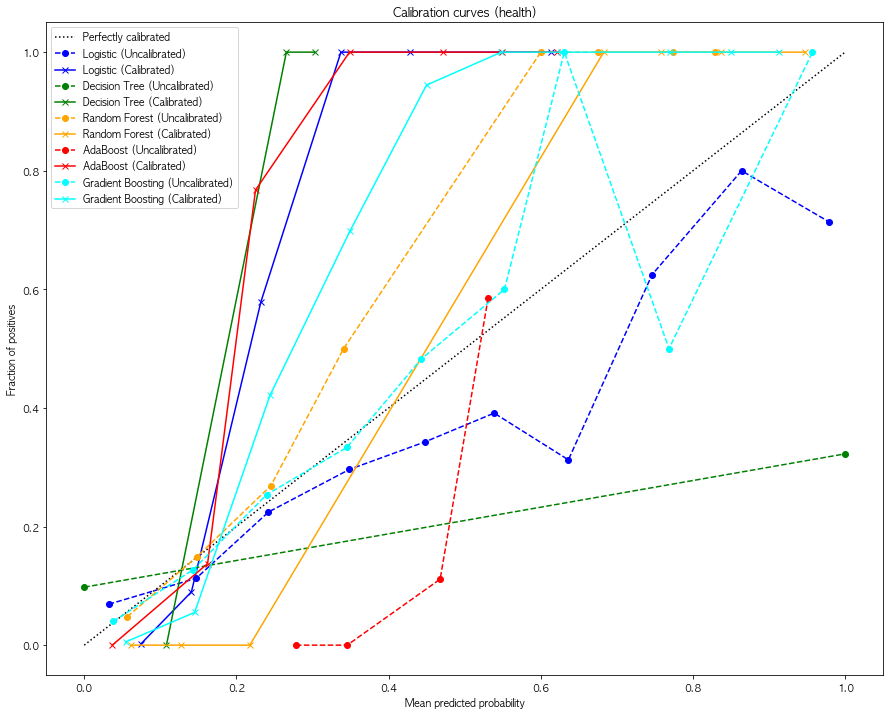

In [102]:
cali_curve_model('health', X_train_health, y_train_health, X_val_health, y_val_health)

                         category     brier       ece
0           Logistic-Uncalibrated  0.115459  0.044937
1             Logistic-Calibrated  0.106231  0.021962
2      Decision Tree-Uncalibrated  0.219841  0.104762
3        Decision Tree-Calibrated  0.105373  0.000000
4      Random Forest-Uncalibrated  0.111121  0.023885
5        Random Forest-Calibrated  0.022963  0.098542
6           AdaBoost-Uncalibrated  0.229439  0.000000
7             AdaBoost-Calibrated  0.107660  0.036080
8  Gradient Boosting-Uncalibrated  0.107604  0.013006
9    Gradient Boosting-Calibrated  0.083084  0.125647


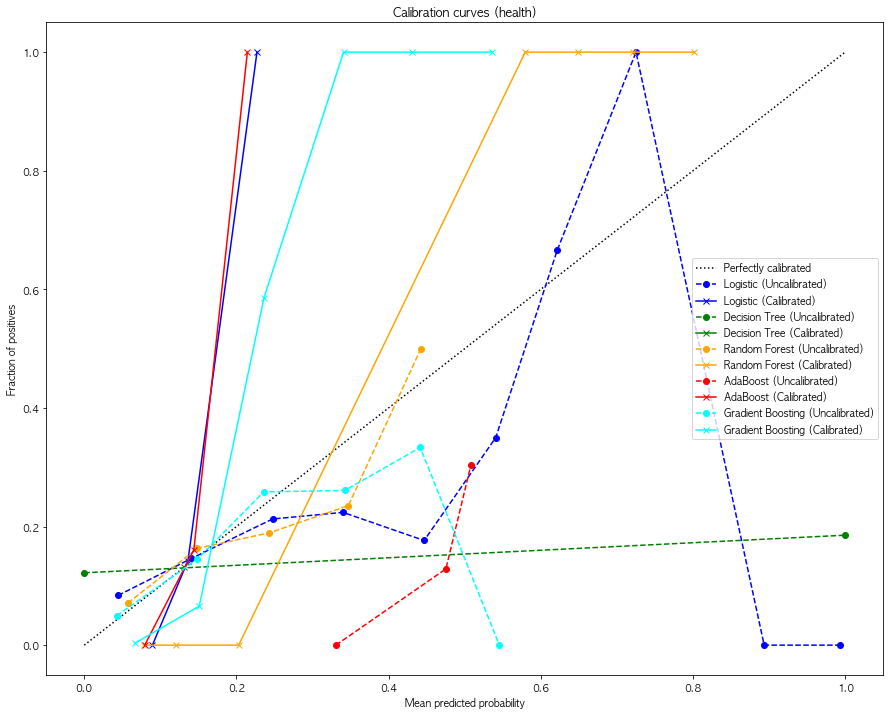

In [184]:
cali_curve_model_feature('health', X_train_health, y_train_health, X_val_health, y_val_health)

                         category     brier       ece
0           Logistic-Uncalibrated  0.104822  0.048344
1             Logistic-Calibrated  0.093772  0.098071
2      Decision Tree-Uncalibrated  0.192857  0.083333
3        Decision Tree-Calibrated  0.065674  0.086513
4      Random Forest-Uncalibrated  0.098127  0.011697
5        Random Forest-Calibrated  0.010146  0.058728
6           AdaBoost-Uncalibrated  0.218083  0.004572
7             AdaBoost-Calibrated  0.091447  0.064329
8  Gradient Boosting-Uncalibrated  0.089100  0.018075
9    Gradient Boosting-Calibrated  0.062827  0.094709


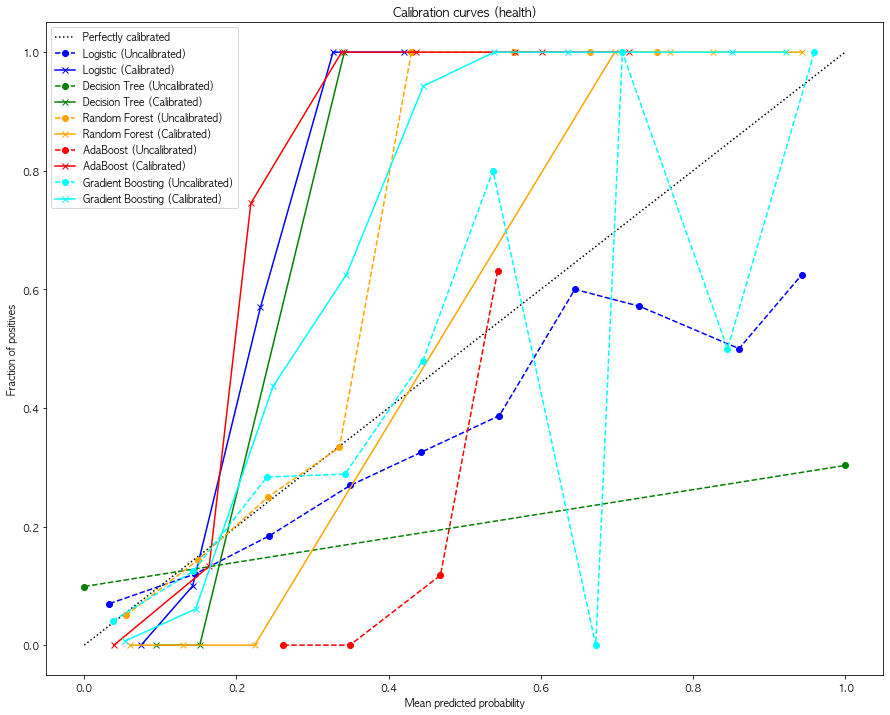

In [220]:
# 총구매빈도 추가
cali_curve_model_feature('health', X_train_health, y_train_health, X_val_health, y_val_health)

## Display

In [221]:
display_df = pd.read_csv('../data/display/display_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 9):
    display_df.loc[display_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
display_df = display_df.fillna('')

display_df = mapping_(display_df)
X_train_display, X_val_display, y_train_display, y_val_display = split_df(display_df)

In [222]:
print(f'display 총 데이터 개수: {len(display_df)}')
print(f'display X_train 데이터 개수: {len(X_train_display)}')
print(f'display y_train 데이터 개수: {len(y_train_display)}')
print(f'display X_val 데이터 개수: {len(X_val_display)}')
print(f'display y_val 데이터 개수: {len(y_val_display)}')

display 총 데이터 개수: 62058
display X_train 데이터 개수: 46543
display y_train 데이터 개수: 46543
display X_val 데이터 개수: 15515
display y_val 데이터 개수: 15515


                         category     brier       ece
0           Logistic-Uncalibrated  0.083905  0.009769
1             Logistic-Calibrated  0.081048  0.021179
2      Decision Tree-Uncalibrated  0.145665  0.075604
3        Decision Tree-Calibrated  0.057866  0.127665
4      Random Forest-Uncalibrated  0.080288  0.015524
5        Random Forest-Calibrated  0.006525  0.044928
6           AdaBoost-Uncalibrated  0.230813  0.000000
7             AdaBoost-Calibrated  0.075893  0.027010
8  Gradient Boosting-Uncalibrated  0.074872  0.008646
9    Gradient Boosting-Calibrated  0.070410  0.014350


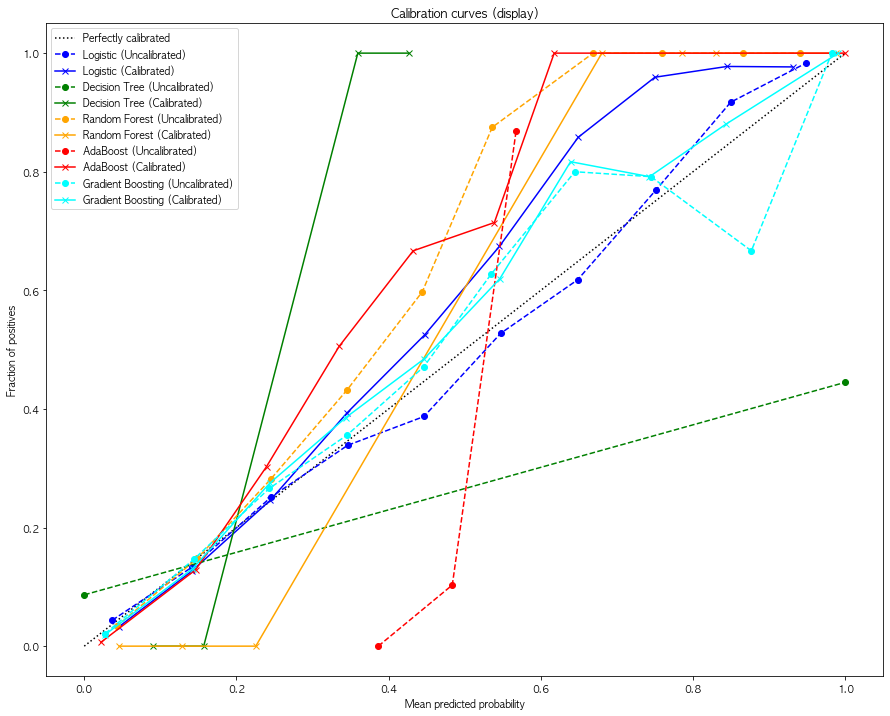

In [105]:
cali_curve_model('display', X_train_display, y_train_display, X_val_display, y_val_display)

                         category     brier       ece
0           Logistic-Uncalibrated  0.104386  0.024862
1             Logistic-Calibrated  0.100721  0.034150
2      Decision Tree-Uncalibrated  0.190010  0.100935
3        Decision Tree-Calibrated  0.091834  0.674470
4      Random Forest-Uncalibrated  0.102703  0.011321
5        Random Forest-Calibrated  0.011904  0.081236
6           AdaBoost-Uncalibrated  0.241506  0.000000
7             AdaBoost-Calibrated  0.099413  0.035357
8  Gradient Boosting-Uncalibrated  0.099065  0.009546
9    Gradient Boosting-Calibrated  0.092844  0.016914


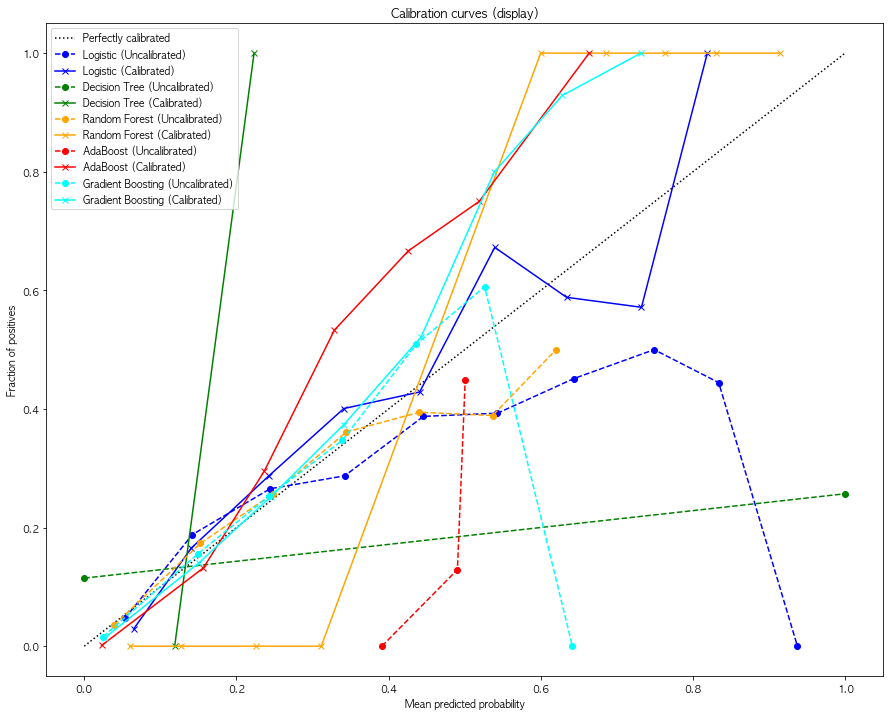

In [188]:
cali_curve_model_feature('display', X_train_display, y_train_display, X_val_display, y_val_display)

                         category     brier       ece
0           Logistic-Uncalibrated  0.089562  0.012177
1             Logistic-Calibrated  0.086726  0.020684
2      Decision Tree-Uncalibrated  0.147728  0.077345
3        Decision Tree-Calibrated  0.059192  0.129166
4      Random Forest-Uncalibrated  0.081470  0.014718
5        Random Forest-Calibrated  0.006887  0.045824
6           AdaBoost-Uncalibrated  0.230635  0.000000
7             AdaBoost-Calibrated  0.076150  0.021774
8  Gradient Boosting-Uncalibrated  0.076330  0.007859
9    Gradient Boosting-Calibrated  0.072023  0.011204


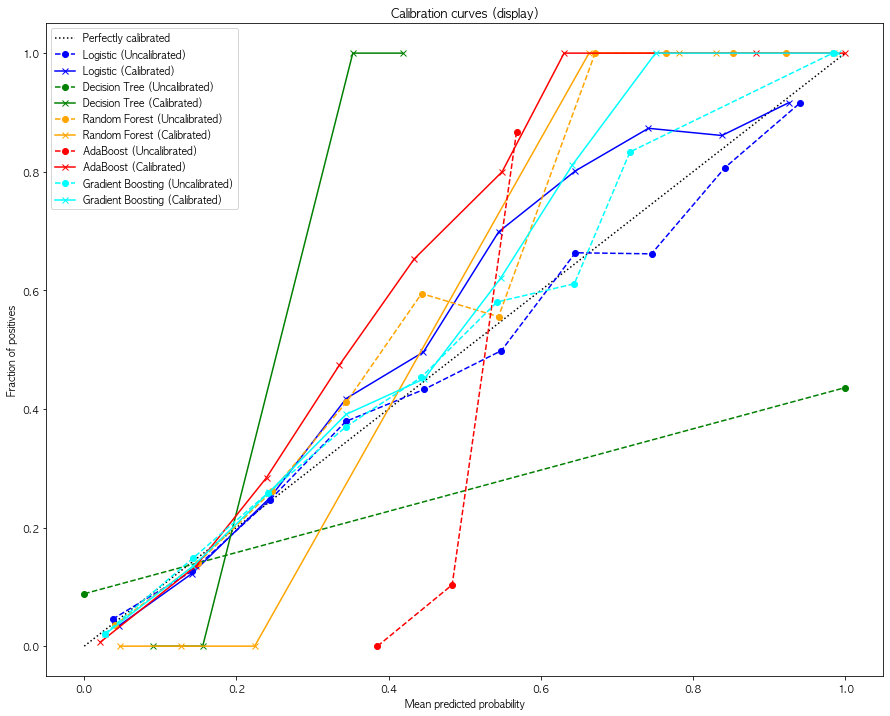

In [223]:
# 총구매빈도 추가
cali_curve_model_feature('display', X_train_display, y_train_display, X_val_display, y_val_display)

## Kitchen

In [224]:
kitchen_df = pd.read_csv('../data/kitchen/kitchen_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 9):
    kitchen_df.loc[kitchen_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
kitchen_df = kitchen_df.fillna('')


kitchen_df = mapping_(kitchen_df)
X_train_kitchen, X_val_kitchen, y_train_kitchen, y_val_kitchen = split_df(kitchen_df)

In [225]:
print(f'kitchen 총 데이터 개수: {len(kitchen_df)}')
print(f'kitchen X_train 데이터 개수: {len(X_train_kitchen)}')
print(f'kitchen y_train 데이터 개수: {len(y_train_kitchen)}')
print(f'kitchen X_val 데이터 개수: {len(X_val_kitchen)}')
print(f'kitchen y_val 데이터 개수: {len(y_val_kitchen)}')

kitchen 총 데이터 개수: 67436
kitchen X_train 데이터 개수: 50577
kitchen y_train 데이터 개수: 50577
kitchen X_val 데이터 개수: 16859
kitchen y_val 데이터 개수: 16859


                         category     brier       ece
0           Logistic-Uncalibrated  0.085482  0.011919
1             Logistic-Calibrated  0.082750  0.020541
2      Decision Tree-Uncalibrated  0.151195  0.078593
3        Decision Tree-Calibrated  0.056900  0.127633
4      Random Forest-Uncalibrated  0.082804  0.017855
5        Random Forest-Calibrated  0.006861  0.046557
6           AdaBoost-Uncalibrated  0.231480  0.000000
7             AdaBoost-Calibrated  0.080120  0.035829
8  Gradient Boosting-Uncalibrated  0.077352  0.011074
9    Gradient Boosting-Calibrated  0.072820  0.013203


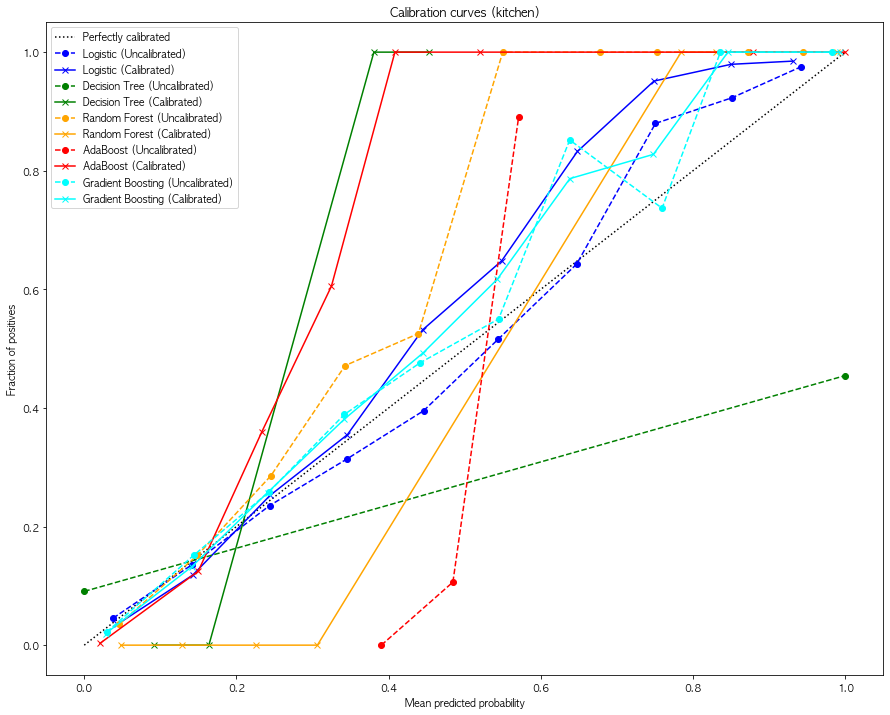

In [108]:
cali_curve_model('kitchen', X_train_kitchen, y_train_kitchen, X_val_kitchen, y_val_kitchen)

                         category     brier       ece
0           Logistic-Uncalibrated  0.109102  0.026220
1             Logistic-Calibrated  0.106025  0.030640
2      Decision Tree-Uncalibrated  0.200605  0.104988
3        Decision Tree-Calibrated  0.091837  0.647700
4      Random Forest-Uncalibrated  0.105558  0.012912
5        Random Forest-Calibrated  0.013481  0.075076
6           AdaBoost-Uncalibrated  0.242508  0.000000
7             AdaBoost-Calibrated  0.104569  0.043412
8  Gradient Boosting-Uncalibrated  0.102539  0.010535
9    Gradient Boosting-Calibrated  0.097116  0.019505


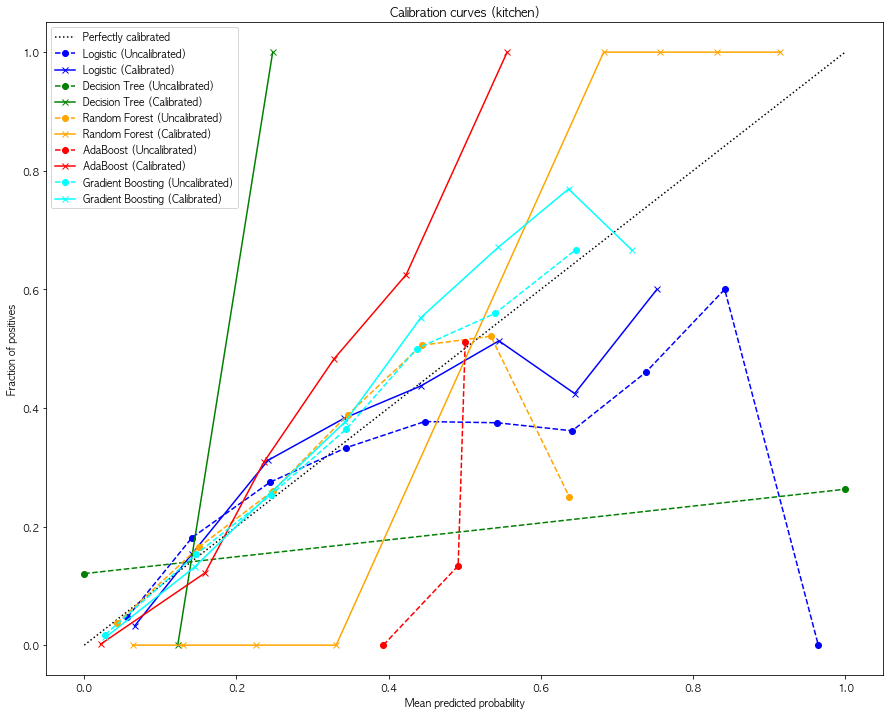

In [191]:
cali_curve_model_feature('kitchen', X_train_kitchen, y_train_kitchen, X_val_kitchen, y_val_kitchen)

                         category     brier       ece
0           Logistic-Uncalibrated  0.091031  0.010650
1             Logistic-Calibrated  0.088757  0.022284
2      Decision Tree-Uncalibrated  0.154636  0.080373
3        Decision Tree-Calibrated  0.057304  0.128134
4      Random Forest-Uncalibrated  0.083943  0.015240
5        Random Forest-Calibrated  0.007335  0.048227
6           AdaBoost-Uncalibrated  0.231590  0.000000
7             AdaBoost-Calibrated  0.080226  0.034733
8  Gradient Boosting-Uncalibrated  0.078163  0.009934
9    Gradient Boosting-Calibrated  0.073718  0.014715


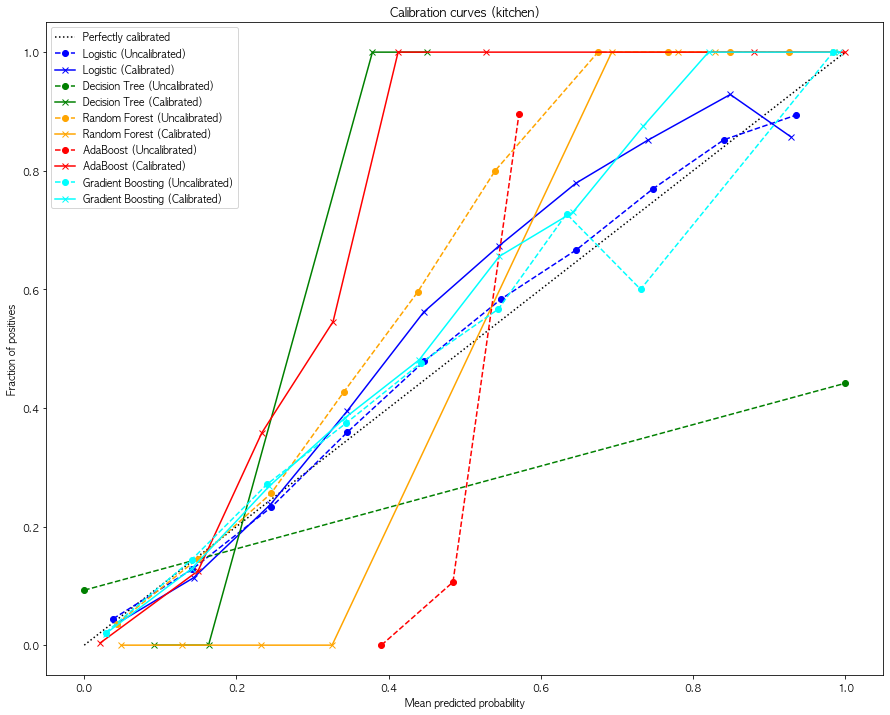

In [228]:
# 총구매빈도 추가
cali_curve_model_feature('kitchen', X_train_kitchen, y_train_kitchen, X_val_kitchen, y_val_kitchen)

## Clean

In [229]:
clean_df = pd.read_csv('../data/clean/clean_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 9):
    clean_df.loc[clean_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
clean_df = clean_df.fillna('')
clean_df = mapping_(clean_df)
X_train_clean, X_val_clean, y_train_clean, y_val_clean = split_df(clean_df)

In [230]:
print(f'clean 총 데이터 개수: {len(clean_df)}')
print(f'clean X_train 데이터 개수: {len(X_train_clean)}')
print(f'clean y_train 데이터 개수: {len(y_train_clean)}')
print(f'clean X_val 데이터 개수: {len(X_val_clean)}')
print(f'clean y_val 데이터 개수: {len(y_val_clean)}')

clean 총 데이터 개수: 72873
clean X_train 데이터 개수: 54654
clean y_train 데이터 개수: 54654
clean X_val 데이터 개수: 18219
clean y_val 데이터 개수: 18219


                         category     brier       ece
0           Logistic-Uncalibrated  0.084599  0.009181
1             Logistic-Calibrated  0.081882  0.020726
2      Decision Tree-Uncalibrated  0.152039  0.078819
3        Decision Tree-Calibrated  0.057489  0.126963
4      Random Forest-Uncalibrated  0.082127  0.017238
5        Random Forest-Calibrated  0.006592  0.045259
6           AdaBoost-Uncalibrated  0.231420  0.000000
7             AdaBoost-Calibrated  0.077892  0.028944
8  Gradient Boosting-Uncalibrated  0.076610  0.008384
9    Gradient Boosting-Calibrated  0.073159  0.012156


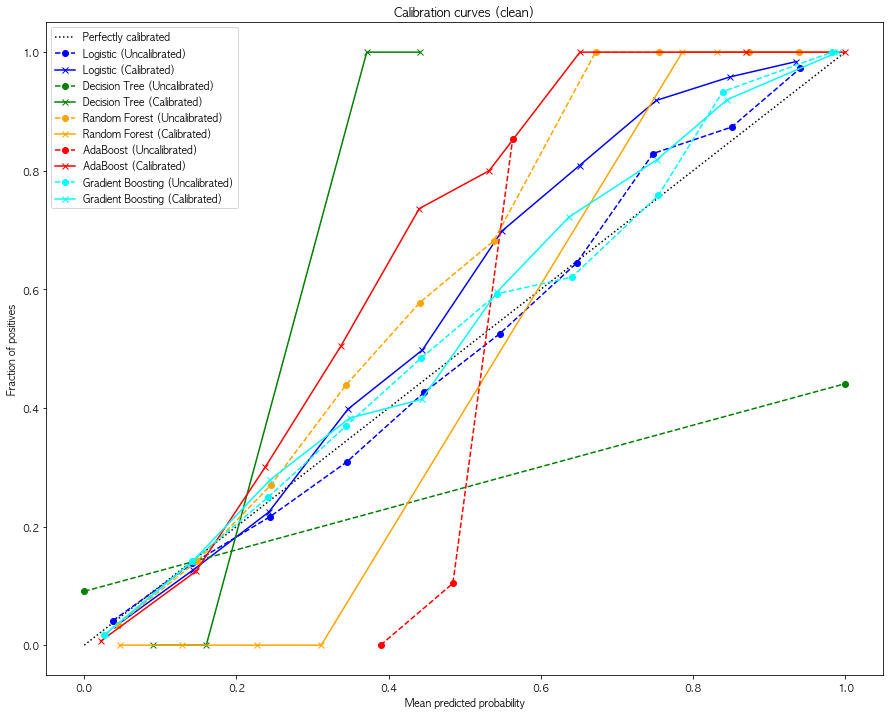

In [111]:
cali_curve_model('clean', X_train_clean, y_train_clean, X_val_clean, y_val_clean)

                         category     brier       ece
0           Logistic-Uncalibrated  0.107651  0.026572
1             Logistic-Calibrated  0.104359  0.035336
2      Decision Tree-Uncalibrated  0.200642  0.102860
3        Decision Tree-Calibrated  0.090714  0.652762
4      Random Forest-Uncalibrated  0.106049  0.007759
5        Random Forest-Calibrated  0.014509  0.077849
6           AdaBoost-Uncalibrated  0.242360  0.000000
7             AdaBoost-Calibrated  0.102849  0.037703
8  Gradient Boosting-Uncalibrated  0.102073  0.006727
9    Gradient Boosting-Calibrated  0.097510  0.016829


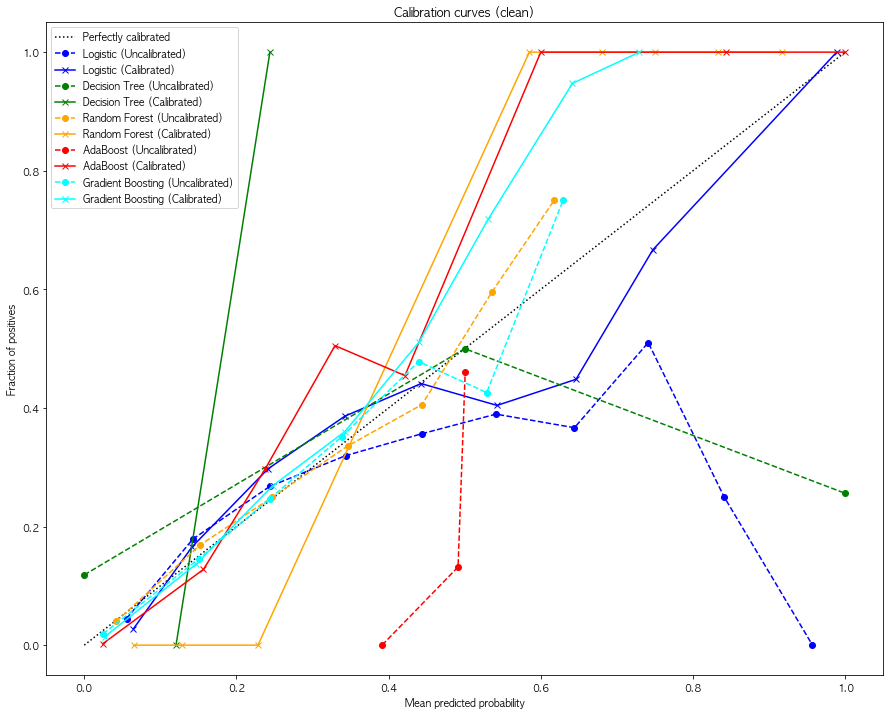

In [194]:
cali_curve_model_feature('clean', X_train_clean, y_train_clean, X_val_clean, y_val_clean)

                         category     brier       ece
0           Logistic-Uncalibrated  0.089572  0.009782
1             Logistic-Calibrated  0.087037  0.020586
2      Decision Tree-Uncalibrated  0.151929  0.078544
3        Decision Tree-Calibrated  0.058845  0.128400
4      Random Forest-Uncalibrated  0.084091  0.016081
5        Random Forest-Calibrated  0.007265  0.047338
6           AdaBoost-Uncalibrated  0.231426  0.000000
7             AdaBoost-Calibrated  0.078510  0.029324
8  Gradient Boosting-Uncalibrated  0.077430  0.010318
9    Gradient Boosting-Calibrated  0.074104  0.010535


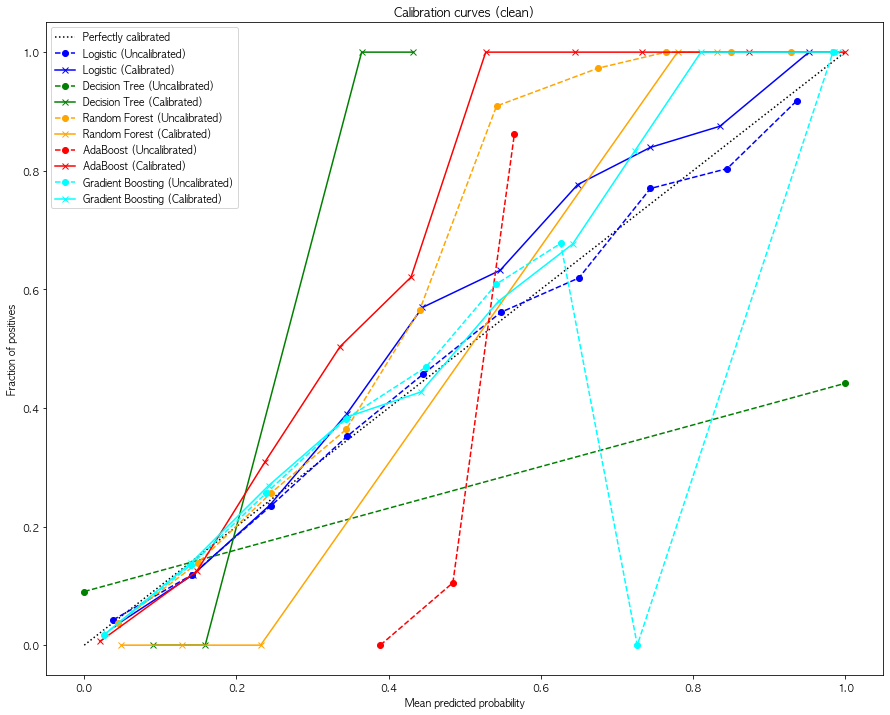

In [231]:
# 총구매빈도 추가
cali_curve_model_feature('clean', X_train_clean, y_train_clean, X_val_clean, y_val_clean)

## Air

In [232]:
air_df = pd.read_csv('../data/air/air_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 9):
    air_df.loc[air_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0

air_df = air_df.fillna('')
air_df = mapping_(air_df)
X_train_air, X_val_air, y_train_air, y_val_air = split_df(air_df)

In [233]:
print(f'air 총 데이터 개수: {len(air_df)}')
print(f'air X_train 데이터 개수: {len(X_train_air)}')
print(f'air y_train 데이터 개수: {len(y_train_air)}')
print(f'air X_val 데이터 개수: {len(X_val_air)}')
print(f'air y_val 데이터 개수: {len(y_val_air)}')

air 총 데이터 개수: 63547
air X_train 데이터 개수: 47660
air y_train 데이터 개수: 47660
air X_val 데이터 개수: 15887
air y_val 데이터 개수: 15887


In [ ]:
air_df.shape

                         category     brier       ece
0           Logistic-Uncalibrated  0.084189  0.006387
1             Logistic-Calibrated  0.081485  0.019952
2      Decision Tree-Uncalibrated  0.146598  0.074400
3        Decision Tree-Calibrated  0.055796  0.122801
4      Random Forest-Uncalibrated  0.082059  0.021050
5        Random Forest-Calibrated  0.006433  0.043959
6           AdaBoost-Uncalibrated  0.230147  0.000000
7             AdaBoost-Calibrated  0.079960  0.027151
8  Gradient Boosting-Uncalibrated  0.075243  0.013948
9    Gradient Boosting-Calibrated  0.070918  0.012662


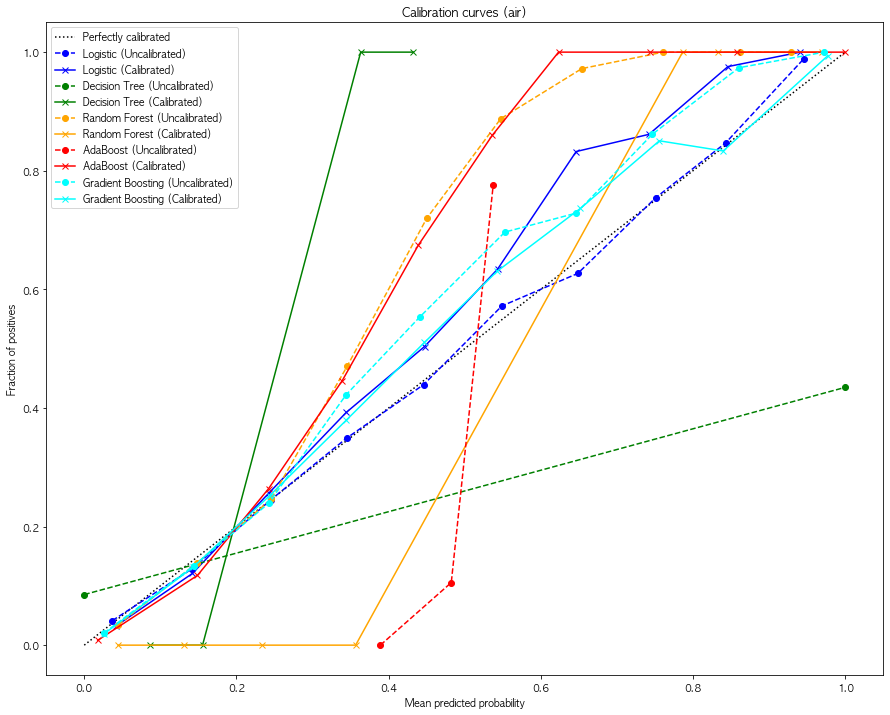

In [115]:
cali_curve_model('air', X_train_air, y_train_air, X_val_air, y_val_air)

                         category     brier       ece
0           Logistic-Uncalibrated  0.104244  0.024534
1             Logistic-Calibrated  0.100850  0.030671
2      Decision Tree-Uncalibrated  0.198527  0.100648
3        Decision Tree-Calibrated  0.095351  0.721817
4      Random Forest-Uncalibrated  0.102625  0.005940
5        Random Forest-Calibrated  0.013619  0.076034
6           AdaBoost-Uncalibrated  0.241833  0.000000
7             AdaBoost-Calibrated  0.099461  0.034055
8  Gradient Boosting-Uncalibrated  0.098902  0.007005
9    Gradient Boosting-Calibrated  0.093565  0.023644


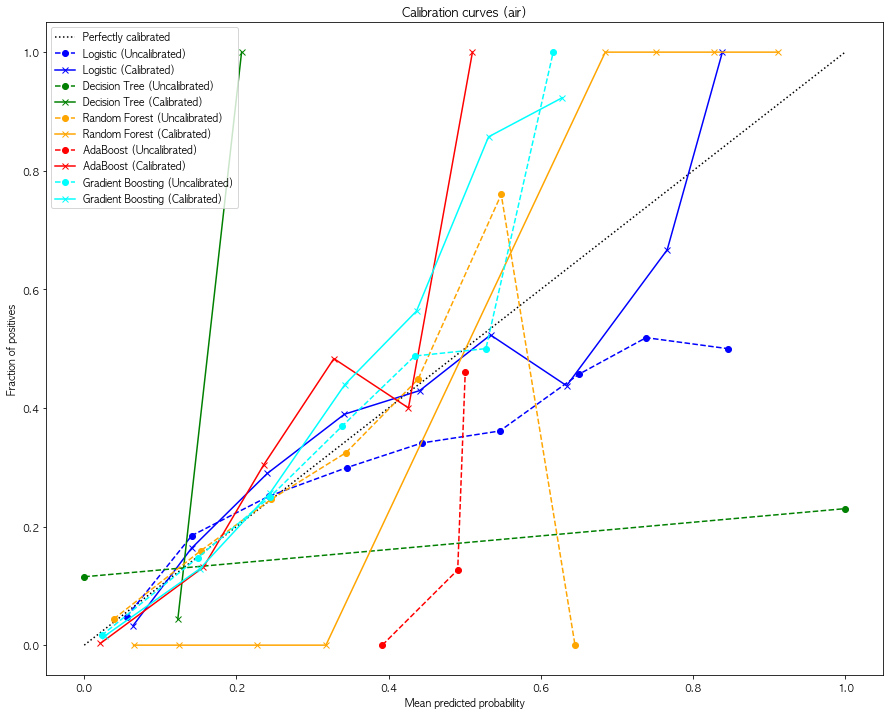

In [197]:
cali_curve_model_feature('air', X_train_air, y_train_air, X_val_air, y_val_air)

                         category     brier       ece
0           Logistic-Uncalibrated  0.085709  0.008749
1             Logistic-Calibrated  0.083320  0.019895
2      Decision Tree-Uncalibrated  0.144395  0.073897
3        Decision Tree-Calibrated  0.058036  0.124109
4      Random Forest-Uncalibrated  0.082386  0.021335
5        Random Forest-Calibrated  0.006349  0.043319
6           AdaBoost-Uncalibrated  0.230104  0.000000
7             AdaBoost-Calibrated  0.080622  0.029081
8  Gradient Boosting-Uncalibrated  0.075150  0.015336
9    Gradient Boosting-Calibrated  0.070877  0.012344


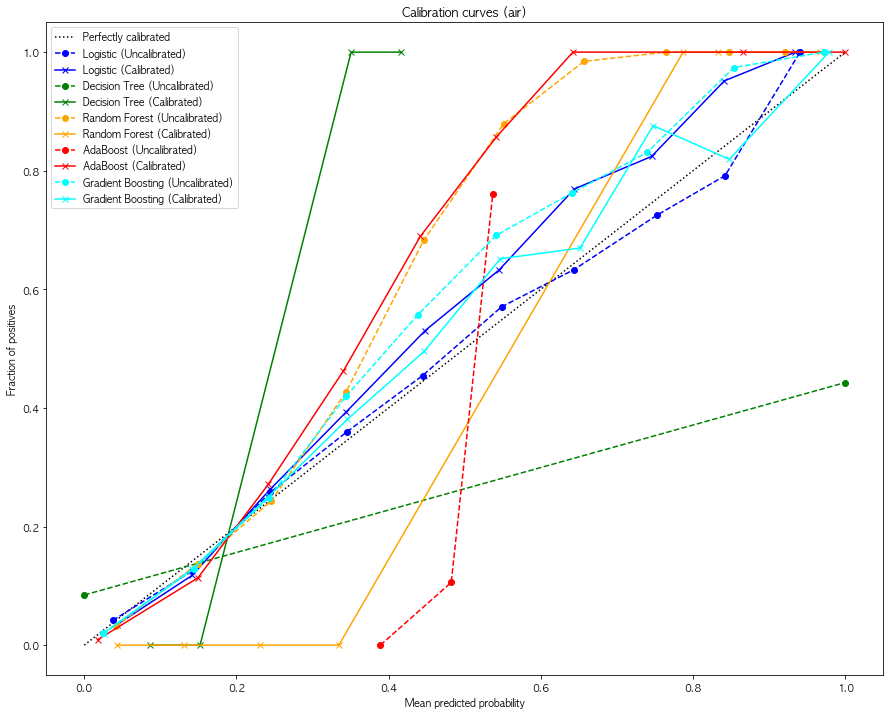

In [234]:
# 총구매빈도 추가
cali_curve_model_feature('air', X_train_air, y_train_air, X_val_air, y_val_air)

## Air - 미세먼지

In [198]:
def split_df_add(df):
    onehot_col = ['멤버십고객여부', '케어십가입여부',
           '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
           '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3',
                   '타겟제품명_4', '타겟제품명_5', '타겟제품명_6', '타겟제품명_7', '타겟제품명_8', '주구매제품카테고리']
    
    # Convert columns in onehot_col to string
    for col in onehot_col:
        df[col] = df[col].astype(str)

    # 원핫 인코딩
    df_encoded = pd.get_dummies(df[onehot_col])
    df_encoded = pd.concat([df_encoded, df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
                                                '건강관리가전품목수', '총구매빈도', '케어솔루션품목수', '케어십품목수', 
                                                'Only&Best품목수', '최대구매가격대', '연령대', 
                                                '금액_1', '금액_2', '금액_3', '금액_4', '금액_5', '금액_6', '금액_7', '금액_8',
                                                '년도_1', '년도_2', '년도_3', '년도_4', '년도_5', '년도_6', '년도_7', '년도_8', 
                                                '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', 
                                                '미세먼지_1', '미세먼지_2', '미세먼지_3', '미세먼지_4', '미세먼지_5', 
                                                '미세먼지_6', '미세먼지_7', '미세먼지_8', '기온_1', '기온_2', '기온_3', '기온_4',
                                                '기온_5', '기온_6', '기온_7', '기온_8', 'label_y']]], axis = 1)
    X = df_encoded.drop('label_y', axis=1)
    y = df_encoded['label_y']
    column_names = X.columns
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)
    
    X_train, X_val, y_train, y_val = train_test_split(X_scaled_df, y, test_size=0.25, random_state = 42)
    
    return X_train, X_val, y_train, y_val

In [235]:
# ## 가공변수 제거

# def split_df_add(df):
#     onehot_col = ['멤버십고객여부', '케어십가입여부',
#            '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
#            '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3',
#                    '타겟제품명_4', '타겟제품명_5', '타겟제품명_6', '타겟제품명_7', '타겟제품명_8']
    
#     # Convert columns in onehot_col to string
#     for col in onehot_col:
#         df[col] = df[col].astype(str)

#     # 원핫 인코딩
#     df_encoded = pd.get_dummies(df[onehot_col])
#     df_encoded = pd.concat([df_encoded, df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
#                                                 '건강관리가전품목수', '케어솔루션품목수', '케어십품목수', 
#                                                 'Only&Best품목수', '연령대', '총구매빈도',
#                                                 '금액_1', '금액_2', '금액_3', '금액_4', '금액_5', '금액_6', '금액_7', '금액_8',
#                                                 '년도_1', '년도_2', '년도_3', '년도_4', '년도_5', '년도_6', '년도_7', '년도_8', 
#                                                 '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', 
#                                                 '미세먼지_1', '미세먼지_2', '미세먼지_3', '미세먼지_4', '미세먼지_5', 
#                                                 '미세먼지_6', '미세먼지_7', '미세먼지_8', '기온_1', '기온_2', '기온_3', '기온_4',
#                                                 '기온_5', '기온_6', '기온_7', '기온_8', 'label_y']]], axis = 1)
#     X = df_encoded.drop('label_y', axis=1)
#     y = df_encoded['label_y']
#     column_names = X.columns
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)
    
#     X_train, X_val, y_train, y_val = train_test_split(X_scaled_df, y, test_size=0.25, random_state = 42)
    
#     return X_train, X_val, y_train, y_val

In [236]:
air_df2 = pd.read_csv('../data/air_외부변수/air_df_값생성_미세먼지_2023제거.csv', index_col = 0)

for i in range(1, 9):    
    air_df2.loc[air_df2[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    air_df2.loc[air_df2[f'미세먼지_{i}'].isnull(), f'미세먼지_{i}'] = 0
    air_df2.loc[air_df2[f'기온_{i}'].isnull(), f'기온_{i}'] = 0


air_df2 = air_df2.fillna('')
air_df2 = mapping_(air_df2)
X_train_air2, X_val_air2, y_train_air2, y_val_air2 = split_df_add(air_df2)

In [237]:
print(f'air 총 데이터 개수: {len(air_df2)}')
print(f'air X_train 데이터 개수: {len(X_train_air2)}')
print(f'air y_train 데이터 개수: {len(y_train_air2)}')
print(f'air X_val 데이터 개수: {len(X_val_air2)}')
print(f'air y_val 데이터 개수: {len(y_val_air2)}')

air 총 데이터 개수: 63547
air X_train 데이터 개수: 47660
air y_train 데이터 개수: 47660
air X_val 데이터 개수: 15887
air y_val 데이터 개수: 15887


                         category     brier       ece
0           Logistic-Uncalibrated  0.084197  0.007237
1             Logistic-Calibrated  0.081422  0.020138
2      Decision Tree-Uncalibrated  0.144206  0.075785
3        Decision Tree-Calibrated  0.058183  0.125829
4      Random Forest-Uncalibrated  0.082417  0.022515
5        Random Forest-Calibrated  0.006540  0.044262
6           AdaBoost-Uncalibrated  0.230102  0.000000
7             AdaBoost-Calibrated  0.079714  0.029456
8  Gradient Boosting-Uncalibrated  0.075232  0.014889
9    Gradient Boosting-Calibrated  0.070680  0.012634


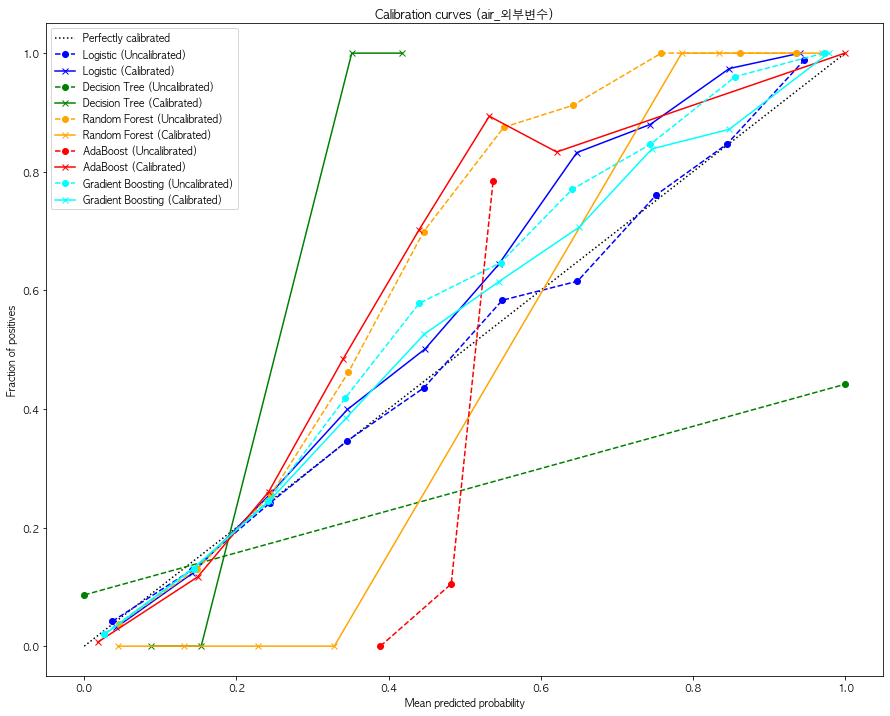

In [119]:
cali_curve_model('air_외부변수', X_train_air2, y_train_air2, X_val_air2, y_val_air2)

                         category     brier       ece
0           Logistic-Uncalibrated  0.104244  0.024502
1             Logistic-Calibrated  0.100773  0.030565
2      Decision Tree-Uncalibrated  0.195569  0.100963
3        Decision Tree-Calibrated  0.094506  0.720237
4      Random Forest-Uncalibrated  0.102605  0.003904
5        Random Forest-Calibrated  0.012924  0.074635
6           AdaBoost-Uncalibrated  0.241814  0.000000
7             AdaBoost-Calibrated  0.099096  0.036111
8  Gradient Boosting-Uncalibrated  0.098872  0.007180
9    Gradient Boosting-Calibrated  0.093205  0.025979


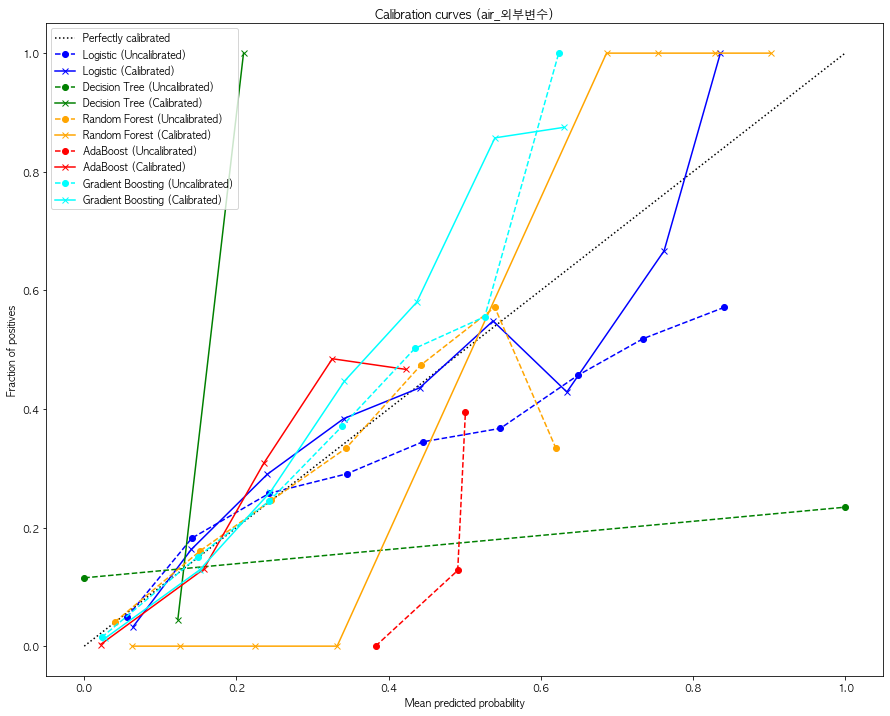

In [205]:
cali_curve_model_feature('air_외부변수', X_train_air2, y_train_air2, X_val_air2, y_val_air2)

                         category     brier       ece
0           Logistic-Uncalibrated  0.085721  0.009021
1             Logistic-Calibrated  0.083263  0.020050
2      Decision Tree-Uncalibrated  0.144458  0.075282
3        Decision Tree-Calibrated  0.058907  0.126724
4      Random Forest-Uncalibrated  0.082420  0.023950
5        Random Forest-Calibrated  0.006530  0.044084
6           AdaBoost-Uncalibrated  0.230119  0.000000
7             AdaBoost-Calibrated  0.080487  0.033089
8  Gradient Boosting-Uncalibrated  0.075286  0.014846
9    Gradient Boosting-Calibrated  0.070656  0.011818


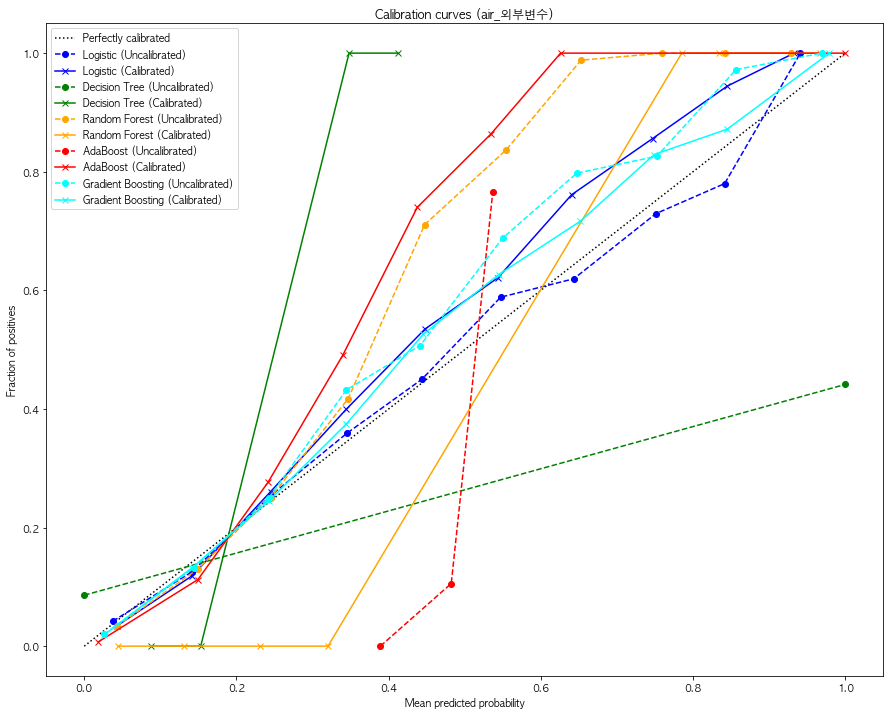

In [238]:
# 총구매빈도 추가
cali_curve_model_feature('air_외부변수', X_train_air2, y_train_air2, X_val_air2, y_val_air2)

## etc


In [120]:
etc_df = pd.read_csv('../data/etc/etc_df_값생성_2023제거.csv', index_col = 0)

etc_df.loc[etc_df['년도_1'].isnull(), '년도_1'] = 0
etc_df.loc[etc_df['년도_2'].isnull(), '년도_2'] = 0
etc_df.loc[etc_df['년도_3'].isnull(), '년도_3'] = 0

etc_df = etc_df.fillna('')
etc_df = mapping_(etc_df)

onehot_col = ['멤버십고객여부', '케어십가입여부',
           '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
           '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3', '주구매제품카테고리']

for col in onehot_col:
    etc_df[col] = etc_df[col].astype(str)
# 원핫 인코딩
df_encoded = pd.get_dummies(etc_df[onehot_col])
df_encoded = pd.concat([df_encoded, etc_df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
                                            '건강관리가전품목수', '총구매빈도', '케어솔루션품목수', '케어십품목수', 
                                            'Only&Best품목수', '최대구매가격대', '연령대',
                                            '금액_1', '금액_2', '금액_3',
                                            '년도_1', '년도_2', '년도_3',
                                            '월_1', '월_2', '월_3', 
                                            'label_y']]], axis = 1)

for col in onehot_col:
    etc_df[col] = etc_df[col].astype(str)
        
X = df_encoded.drop('label_y', axis=1)
y = df_encoded['label_y']
column_names_etc = X.columns

scaler_etc = StandardScaler()
X_scaled_etc = scaler_etc.fit_transform(X)

X_scaled_df_etc = pd.DataFrame(X_scaled_etc, columns=column_names_etc)

X_train_etc, X_val_etc, y_train_etc, y_val_etc = train_test_split(X_scaled_df_etc, y, test_size=0.25, random_state = 42)


In [239]:
# ## 가공변수 제거
# etc_df = pd.read_csv('../data/etc/etc_df_값생성_2023제거.csv', index_col = 0)

# etc_df.loc[etc_df['년도_1'].isnull(), '년도_1'] = 0
# etc_df.loc[etc_df['년도_2'].isnull(), '년도_2'] = 0
# etc_df.loc[etc_df['년도_3'].isnull(), '년도_3'] = 0

# etc_df = etc_df.fillna('')
# etc_df = mapping_(etc_df)

# onehot_col = ['멤버십고객여부', '케어십가입여부',
#            '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
#            '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3']

# for col in onehot_col:
#     etc_df[col] = etc_df[col].astype(str)
# # 원핫 인코딩
# df_encoded = pd.get_dummies(etc_df[onehot_col])
# df_encoded = pd.concat([df_encoded, etc_df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
#                                             '건강관리가전품목수', '케어솔루션품목수', '케어십품목수', 
#                                             'Only&Best품목수', '연령대', '총구매빈도',
#                                             '금액_1', '금액_2', '금액_3',
#                                             '년도_1', '년도_2', '년도_3',
#                                             '월_1', '월_2', '월_3', 
#                                             'label_y']]], axis = 1)

# for col in onehot_col:
#     etc_df[col] = etc_df[col].astype(str)
        
# X = df_encoded.drop('label_y', axis=1)
# y = df_encoded['label_y']
# column_names_etc = X.columns

# scaler_etc = StandardScaler()
# X_scaled_etc = scaler_etc.fit_transform(X)

# X_scaled_df_etc = pd.DataFrame(X_scaled_etc, columns=column_names_etc)

# X_train_etc, X_val_etc, y_train_etc, y_val_etc = train_test_split(X_scaled_df_etc, y, test_size=0.25, random_state = 42)


In [240]:
print(f'etc 총 데이터 개수: {len(etc_df)}')
print(f'etc X_train 데이터 개수: {len(X_train_etc)}')
print(f'etc y_train 데이터 개수: {len(y_train_etc)}')
print(f'etc X_val 데이터 개수: {len(X_val_etc)}')
print(f'etc y_val 데이터 개수: {len(y_val_etc)}')

etc 총 데이터 개수: 397
etc X_train 데이터 개수: 297
etc y_train 데이터 개수: 297
etc X_val 데이터 개수: 100
etc y_val 데이터 개수: 100


                         category     brier       ece
0           Logistic-Uncalibrated  0.211836  0.217107
1             Logistic-Calibrated  0.090839  0.234009
2      Decision Tree-Uncalibrated  0.190000  0.140000
3        Decision Tree-Calibrated  0.125625  0.129637
4      Random Forest-Uncalibrated  0.157541  0.091518
5        Random Forest-Calibrated  0.068603  0.274663
6           AdaBoost-Uncalibrated  0.224099  0.031985
7             AdaBoost-Calibrated  0.155728  0.050265
8  Gradient Boosting-Uncalibrated  0.148420  0.114068
9    Gradient Boosting-Calibrated  0.083299  0.297680


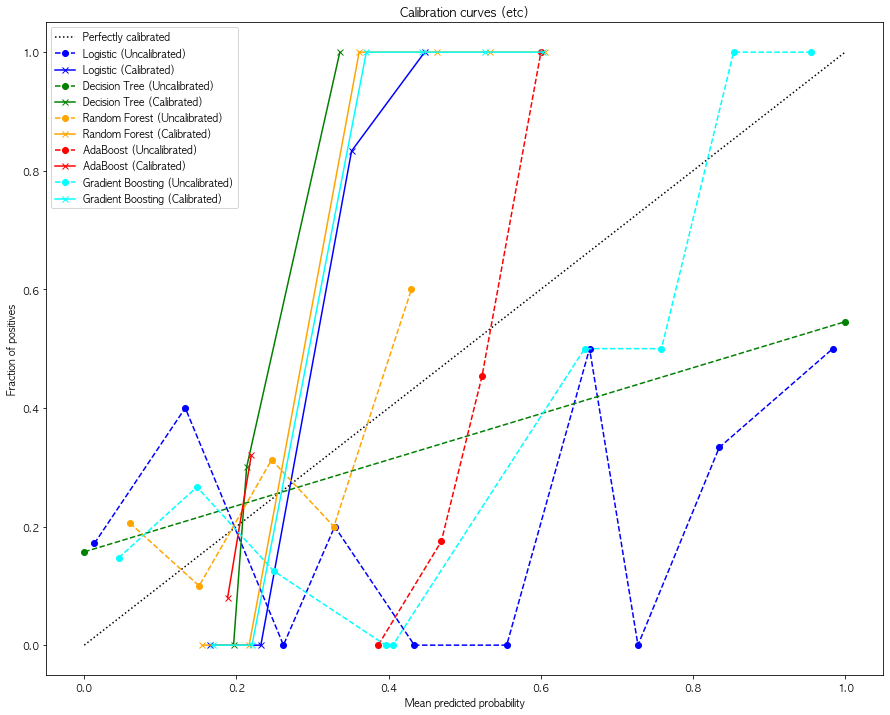

In [122]:
cali_curve_model('etc', X_train_etc, y_train_etc, X_val_etc, y_val_etc)

                         category     brier       ece
0           Logistic-Uncalibrated  0.289732  0.233215
1             Logistic-Calibrated  0.130097  0.281579
2      Decision Tree-Uncalibrated  0.350000  0.140000
3        Decision Tree-Calibrated  0.150997  0.002462
4      Random Forest-Uncalibrated  0.165251  0.070036
5        Random Forest-Calibrated  0.128532  0.488135
6           AdaBoost-Uncalibrated  0.237105  0.000000
7             AdaBoost-Calibrated  0.193476  0.291359
8  Gradient Boosting-Uncalibrated  0.192711  0.157118
9    Gradient Boosting-Calibrated  0.114323  0.309478


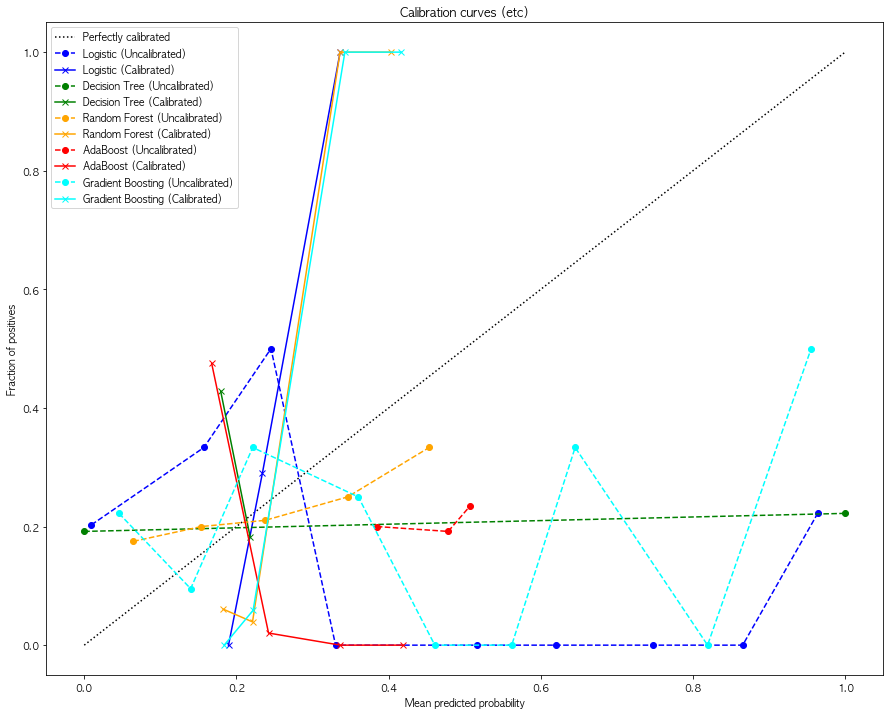

In [208]:
cali_curve_model_feature('etc', X_train_etc, y_train_etc, X_val_etc, y_val_etc)

                         category     brier       ece
0           Logistic-Uncalibrated  0.228271  0.199256
1             Logistic-Calibrated  0.114452  0.250324
2      Decision Tree-Uncalibrated  0.220000  0.160000
3        Decision Tree-Calibrated  0.135255  0.584544
4      Random Forest-Uncalibrated  0.161485  0.115090
5        Random Forest-Calibrated  0.082526  0.298912
6           AdaBoost-Uncalibrated  0.221514  0.000000
7             AdaBoost-Calibrated  0.145595  0.473344
8  Gradient Boosting-Uncalibrated  0.153684  0.128549
9    Gradient Boosting-Calibrated  0.123408  0.236974


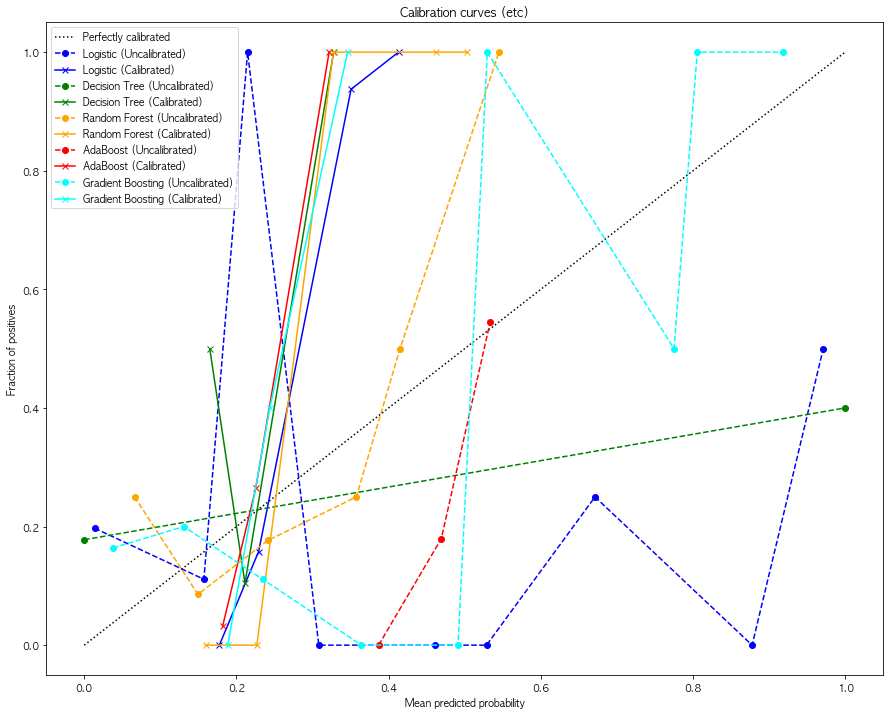

In [241]:
# 총구매빈도 추가
cali_curve_model_feature('etc', X_train_etc, y_train_etc, X_val_etc, y_val_etc)

## All

In [259]:
all_df = pd.read_csv('../data/all/all_df_값생성_2023제거.csv', index_col = 0)


for i in range(1, 9):    
    all_df.loc[all_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
all_df = all_df.fillna('')

all_df = mapping_(all_df)
X_train_all, X_val_all, y_train_all, y_val_all = split_df(all_df)

In [260]:
print(f'all 총 데이터 개수: {len(all_df)}')
print(f'all X_train 데이터 개수: {len(X_train_all)}')
print(f'all y_train 데이터 개수: {len(y_train_all)}')
print(f'all X_val 데이터 개수: {len(X_val_all)}')
print(f'all y_val 데이터 개수: {len(y_val_all)}')

all 총 데이터 개수: 102691
all X_train 데이터 개수: 77018
all y_train 데이터 개수: 77018
all X_val 데이터 개수: 25673
all y_val 데이터 개수: 25673


                         category     brier       ece
0           Logistic-Uncalibrated  0.082171  0.007548
1             Logistic-Calibrated  0.079605  0.023536
2      Decision Tree-Uncalibrated  0.151093  0.075877
3        Decision Tree-Calibrated  0.053362  0.083814
4      Random Forest-Uncalibrated  0.081107  0.018190
5        Random Forest-Calibrated  0.007235  0.054279
6           AdaBoost-Uncalibrated  0.231582  0.010527
7             AdaBoost-Calibrated  0.077946  0.024196
8  Gradient Boosting-Uncalibrated  0.076392  0.019534
9    Gradient Boosting-Calibrated  0.073283  0.008470


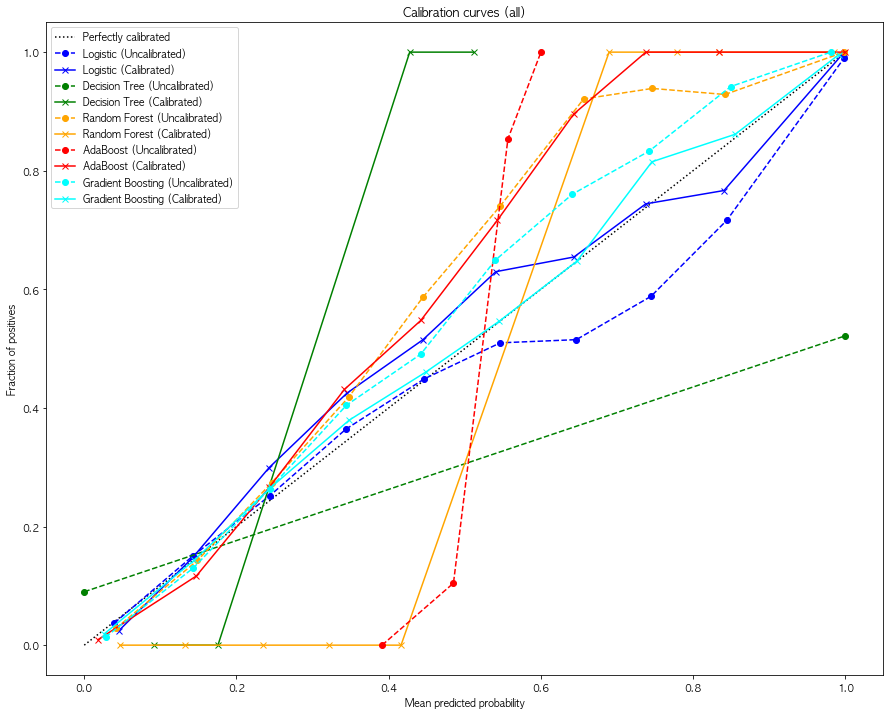

In [261]:
cali_curve_model('all', X_train_all, y_train_all, X_val_all, y_val_all)

                         category     brier       ece
0           Logistic-Uncalibrated  0.082403  0.009410
1             Logistic-Calibrated  0.080112  0.021795
2      Decision Tree-Uncalibrated  0.146886  0.074787
3        Decision Tree-Calibrated  0.051780  0.082927
4      Random Forest-Uncalibrated  0.081305  0.019285
5        Random Forest-Calibrated  0.007155  0.046159
6           AdaBoost-Uncalibrated  0.231616  0.010589
7             AdaBoost-Calibrated  0.078348  0.026890
8  Gradient Boosting-Uncalibrated  0.076648  0.019193
9    Gradient Boosting-Calibrated  0.073846  0.009922


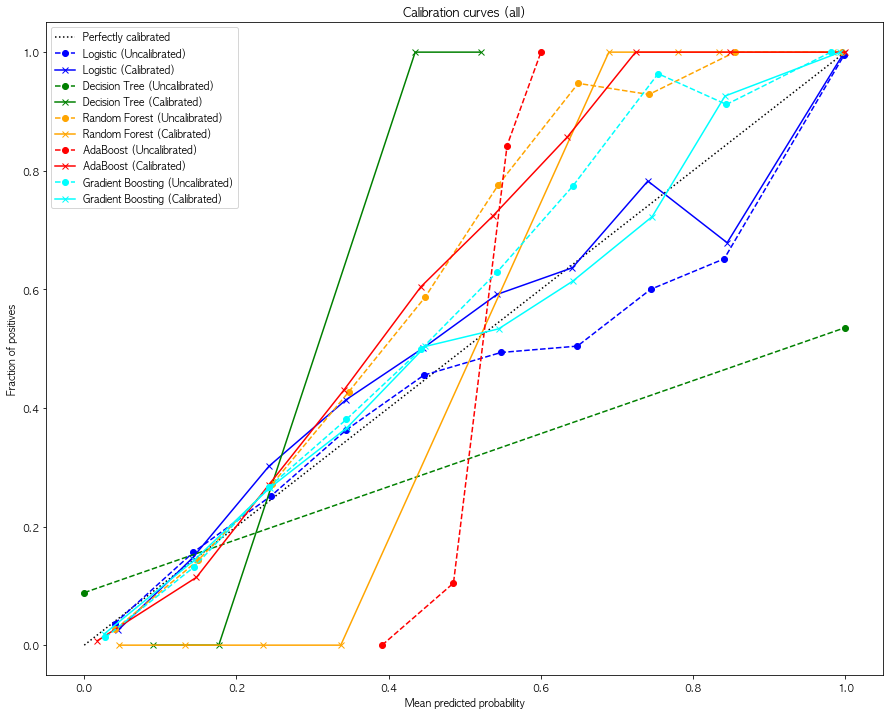

In [211]:
cali_curve_model_feature('all', X_train_all, y_train_all, X_val_all, y_val_all)

                         category     brier       ece
0           Logistic-Uncalibrated  0.082403  0.009401
1             Logistic-Calibrated  0.080112  0.021860
2      Decision Tree-Uncalibrated  0.146925  0.074865
3        Decision Tree-Calibrated  0.053557  0.083449
4      Random Forest-Uncalibrated  0.081391  0.021293
5        Random Forest-Calibrated  0.006957  0.044718
6           AdaBoost-Uncalibrated  0.231616  0.010589
7             AdaBoost-Calibrated  0.078348  0.026904
8  Gradient Boosting-Uncalibrated  0.076648  0.019193
9    Gradient Boosting-Calibrated  0.073842  0.009983


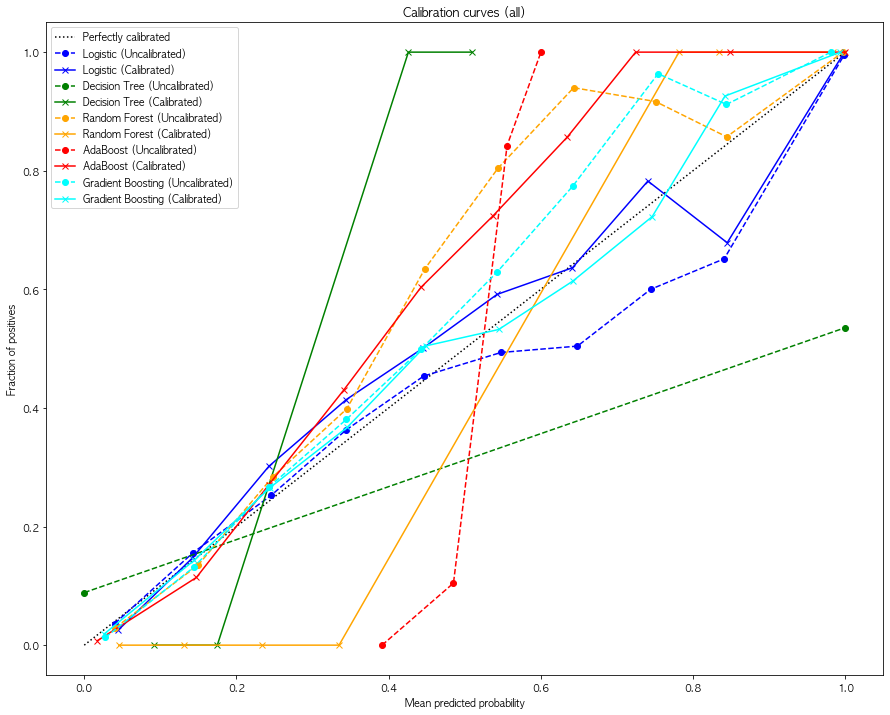

In [244]:
# 총구매빈도 추가
cali_curve_model_feature('all', X_train_all, y_train_all, X_val_all, y_val_all)

# XAI

In [ ]:

    
def xai_feature_importance(category_name, bestmodel, X_train):
    with open(f'../data/{category_name}/save_model/{category_name}_{bestmodel}_calibration_model.pkl', 'rb') as f:
        xai_model = pickle.load(f)
        
    xai_explainer = shap.Explainer(xai_model.predict_proba, X_train)
    xai_shap_values = xai_explainer(X_train)
    
    shap.plots.bar(xai_shap_values[:,:,1])
    
    plt.title("SHAP Feature Importance")
    print("Type of xai_shap_values:", type(xai_shap_values))
    plt.savefig(f'../data/{category_name}/image/{category_name}_xai_feature_importance.png')
    plt.show()

In [ ]:
def xai_feature_importance_mean(category_name, bestmodel, X_train):
    with open(f'../data/{category_name}/save_model/{category_name}_{bestmodel}_calibration_model.pkl', 'rb') as f:
        xai_model = pickle.load(f)
    xai_explainer = shap.Explainer(xai_model.predict_proba, X_train)
    xai_shap_values = xai_explainer(X_train)
    
    # NumPy 배열로 변환 (필요한 경우)
    if not isinstance(xai_shap_values, np.ndarray):
        xai_shap_values = xai_shap_values.values

    # 모든 클래스에 대한 평균 SHAP 값을 계산합니다.
    shap_values_mean = np.mean(xai_shap_values, axis=-1)

    shap.summary_plot(shap_values_mean, X_train, plot_type="bar")
    plt.title("SHAP Feature Importance")
    plt.savefig(f'../data/{category_name}/image/{category_name}_xai_feature_importance_mean.png')
    plt.show()
    

# Probability Distribution (Uncali, Calibration 시각화)

In [ ]:
def plot_proba_dist(category_name, bestmodel, X_val):
    
    with open(f'../data/{category_name}/save_model/{category_name}_{bestmodel}_calibration_model.pkl', 'rb') as f:
        cali_model = pickle.load(f)
    with open(f'../data/{category_name}/save_model/{category_name}_{bestmodel}_uncalibration_model.pkl', 'rb') as f:
            uncali_model = pickle.load(f)

    # 보정 전 예측 확률 계산
    uncali_pred = uncali_model.predict_proba(X_val)[:, 1]
    # 보정 후 예측 확률 계산
    cali_pred = cali_model.predict_proba(X_val)[:, 1]



    # 시각화
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Uncalibrated
    sns.histplot(uncali_pred, bins=30, kde=False, color='skyblue', stat='count', element='bars', ax=axes[0])
    axes[0].set_xlabel('Predicted Scores')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Uncalibrated - Probability Distribution')
    axes[0].set_xlim(0,1)
    
    # Calibrated
    sns.histplot(cali_pred, bins=30, kde=False, color='skyblue', stat='count', element='bars', ax=axes[1])
    axes[1].set_xlabel('Predicted Scores')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Calibrated - Probability Distribution')
    axes[1].set_xlim(0,1)

    plt.tight_layout()

    plt.savefig(f'../data/{category_name}/image/{category_name}_probability_distribution.png')
    plt.show()

# Final 모델 평가 지표

In [262]:
def final_metric(category_name, bestmodel, calibration, X_val, y_val):
    with open(f'../data/{category_name}/save_model/{category_name}_{bestmodel}_{calibration}_model.pkl', 'rb') as f:
        model = pickle.load(f)

    y_pred = model.predict(X_val)

    # 평가 결과를 담을 딕셔너리
    dict2 = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : [],
        'roc_auc' : []
    }



    # 기존 모델 학습 후 모델별 예측 결과    
    r1 = accuracy_score(y_val, y_pred)
    r2 = precision_score(y_val, y_pred)
    r3 = recall_score(y_val, y_pred)
    r4 = f1_score(y_val, y_pred)
    r5 = roc_auc_score(y_val, y_pred)

    dict2['accuracy'].append(r1)
    dict2['precision'].append(r2)
    dict2['recall'].append(r3)
    dict2['f1'].append(r4)
    dict2['roc_auc'].append(r5)

    df200 = pd.DataFrame(dict2)
    df200.to_csv(f'../data/{category_name}/metric/{category_name}_final_bestmodel_모델링_예측결과.csv', encoding = 'utf-8-sig')
    return df200

## Heatlh XAI, Probability Distribution

In [ ]:
xai_feature_importance_mean('health', 'Random Forest', X_train_health)

In [ ]:
plot_proba_dist('health', 'Random Forest',  X_val_health)

## Display XAI, Probability Distribution

In [ ]:
xai_feature_importance('display', 'Gradient Boosting', X_train_display)

In [ ]:
xai_feature_importance_mean('display', 'Gradient Boosting', X_train_display)

In [ ]:
plot_proba_dist('display', 'Gradient Boosting',X_val_display)

## Kitchen XAI, Probability Distribution

In [ ]:
xai_feature_importance('kitchen', 'Logistic', X_train_kitchen)

In [ ]:
plot_proba_dist('kitchen', 'Logistic', X_val_kitchen)

## Clean XAI, Probability Distribution

In [ ]:
xai_feature_importance('clean', 'Gradient Boosting', X_train_clean)

In [ ]:
plot_proba_dist('clean', 'Gradient Boosting',X_val_clean)

## Air XAI, Probability Distribution

In [ ]:
xai_feature_importance('air', 'Random Forest', X_train_air)

In [ ]:
plot_proba_dist('air', 'Random Forest',X_val_air)

## Air2 XAI, Probability Distribution

In [ ]:
plot_proba_dist('air_외부변수', 'Logistic', X_train_air2)

In [ ]:
xai_feature_importance('air_외부변수', 'Logistic', X_train_air2)

In [ ]:
xai_feature_importance_mean('air_외부변수', 'Logistic', X_train_air2)

## etc XAI, Probability Distribution

In [ ]:
xai_feature_importance('etc', 'Random Forest', X_train_etc)

In [ ]:
plot_proba_dist('etc', 'Random Forest',X_val_etc)

## All XAI, Probability Distribution

In [ ]:
xai_feature_importance('all', 'Gradient Boosting', X_train_all)

In [ ]:
plot_proba_dist('all', 'Gradient Boosting',X_val_all)

In [263]:
final_metric('all', 'Gradient Boosting', 'calibration', X_val_all, y_val_all)

,accuracy,precision,recall,f1,roc_auc
0,0.899116,0.842944,0.443622,0.581313,0.714064


# 고객 우선순위 

In [163]:
def sorting_customer(category_name, bestmodel, calibration, X_val, y_val):
    with open(f'../data/{category_name}/save_model/{category_name}_{bestmodel}_{calibration}_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    y_val = y_val.to_frame().reset_index().drop(['label_y'], axis = 1)
    y_val['Predicted Probability'] = y_pred
    y_val = y_val.sort_values('Predicted Probability', ascending = False)
    return y_val


In [167]:
sorting_customer('clean', 'Gradient Boosting', 'uncalibration', X_val_clean, y_val_clean)